# Devoir 1

In [1]:
import numpy

## Les bandits stochastiques

### [10 points] Les environnements de bandits stochastiques

#### Récompenses de distributions de Bernoulli

Complétez le code suivant pour implémenter un simulateur de bandit stochastique à $k$ actions avec récompenses générées par des distributions de Bernoulli. Votre classe doit recevoir en entrée les probabilités de succès de chaque action ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action demandée.

In [2]:
class BernoulliBandit:
    
    def __init__(self, probabilities, seed=None):
        self.probabilities = probabilities
        self.rng = numpy.random.default_rng(seed)

    def play(self, action):
        reward = self.rng.binomial(1, self.probabilities[action])
        return reward

Générez une instance de votre environnement avec la configuration $\boldsymbol \mu = (0.7, 0.6, 0.5)$.

In [3]:
bandit_bernoulli = BernoulliBandit([0.7, 0.6, 0.5])

Montrez que votre environnement fonctionne en jouant 100 fois chaque action sur votre instance. Collectez les récompenses et présentez-les sous la forme d'une figure pour chaque action. Affichez la moyenne empirique pour chaque action.

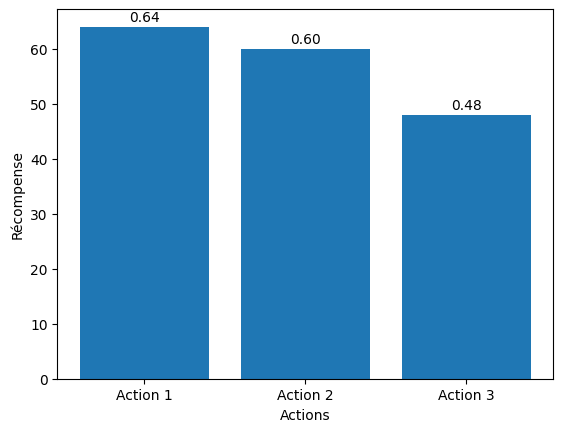

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

rewards = [0, 0, 0]
averages = [0, 0, 0]
for i in range(3):
    for j in range(100):
        rewards[i] += bandit_bernoulli.play(i)
    averages[i] = rewards[i] / 100

for i, v in enumerate(averages):
    ax.text(i, rewards[i] + 1, f'{v:.2f}', ha='center')

ax.bar(['Action 1', 'Action 2', 'Action 3'], rewards)
plt.xlabel('Actions')
plt.ylabel('Récompense')
plt.show()

#### Récompenses de distributions normales

Complétez le code suivant pour implémenter un simulateur de bandit stochastique à $k$ actions avec récompenses générées par des distributions normales. Votre classe doit recevoir en entrée l'espérance et la variance des récompenses pour chaque action, ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action demandée.

In [5]:
import math
class NormalBandit(BernoulliBandit):
    
    def __init__(self, means, variances, seed=None):
        self.means = means
        self.variances = variances
        self.rng = numpy.random.default_rng(seed)
    
    def play(self, action):
        reward = self.rng.normal(self.means[action], math.sqrt(self.variances[action]))
        return reward

Générez une instance de votre environnement avec la configuration $\boldsymbol \mu = (0.7, 0.6, 0.5)$ et une variance de récompenses $\sigma^2 = 1$ pour toutes les actions.

In [6]:
bandit_normal = NormalBandit([0.7, 0.6, 0.5], [1, 1, 1])

Montrez que votre environnement fonctionne en jouant 100 fois chaque action sur votre instance. Collectez les récompenses et affichez la moyenne et la variance empiriques pour chaque action.

In [7]:
for i in range(3):
    rewards = []
    for j in range(100):
        reward = bandit_normal.play(i)
        rewards.append(reward)
    
    moyenne = numpy.mean(rewards)
    variance = numpy.var(rewards)
    print(f'Action {i + 1}: moyenne de {moyenne:.2f} et variance de {variance:.2f}')

Action 1: moyenne de 0.63 et variance de 1.17
Action 2: moyenne de 0.71 et variance de 1.05
Action 3: moyenne de 0.45 et variance de 1.09


### [10 points] Explore-Then-Commit (ETC)

Complétez le code suivant pour implémenter la stratégie ETC. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que la durée $m$ de la phase exploratoire accordée pour chaque action.

In [8]:
def etc(bandit, T, m):
    # initialisation
    probabilities = bandit.probabilities # probabilités des actions
    K = len(probabilities) # nombre d'actions
    a_optim = numpy.argmax(probabilities) # action optimale
    deltas = probabilities[a_optim] - probabilities # gaps de sous-optimalité
    pseudo_regrets_cumulatif = [] # pseudo-regrets cumulatif
    Na_t = numpy.zeros(K) # nombre de fois où chaque action a été jouée
    Sa_t = numpy.zeros(K) # somme des récompenses obtenues pour chaque action
    
    # phase exploration - jouer m fois chaque action
    for action in range(K):
        for t in range(m):
            Na_t[action] += 1 # incrémenter le nombre de fois où l'action a été jouée
            reward = bandit.play(action) # jouer l'action
            Sa_t[action] += reward # incrémenter la somme des récompenses obtenues pour l'action
            # calcul du pseudo-regret cumulatif
            pseudo_regret_t = numpy.dot(deltas.T, Na_t) # pseudo-regret instantanné ?
            pseudo_regrets_cumulatif.append(pseudo_regret_t) 

    # phase exploitation - jouer l'action avec la meilleure moyenne
    meilleure_action = numpy.argmax(Sa_t / Na_t) # sélectionner l'action avec la meilleure moyenne
    for t in range(K*m, T): # jouer les T - K*m tours restants
        Na_t[meilleure_action] += 1
        reward = bandit.play(meilleure_action)
        Sa_t[meilleure_action] += reward
        # calcul du pseudo-regret cumulatif
        pseudo_regret_t = numpy.dot(deltas.T, Na_t) # pseudo-regret instantanné ?
        pseudo_regrets_cumulatif.append(pseudo_regret_t)
    
    pseudo_regret_cumulatif = numpy.array(pseudo_regrets_cumulatif) # convertir la liste en array numpy pour faciliter le moyennage
    return Na_t, Sa_t, pseudo_regret_cumulatif



Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie ETC sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 2000$. Comparez ETC pour $m=50$ tirages exploratoires par action avec ETC pour $m$ optimal selon la théorie : $$m_\text{optimal} = \left\lceil \frac{4 \sigma^2}{\Delta_-^2} \ln \left( \frac{T \Delta_-^2}{4 \sigma^2} \right) \right\rceil \quad \text{avec } \Delta_- = \min_{a\neq a_\star} \Delta_a$$

Supposez que le gap de sous-optimalité minimal $\Delta_-$ est connu.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie. Affichez le pourcentage des réalisations pour lesquelles chaque variante a pu exploiter l'action optimale.

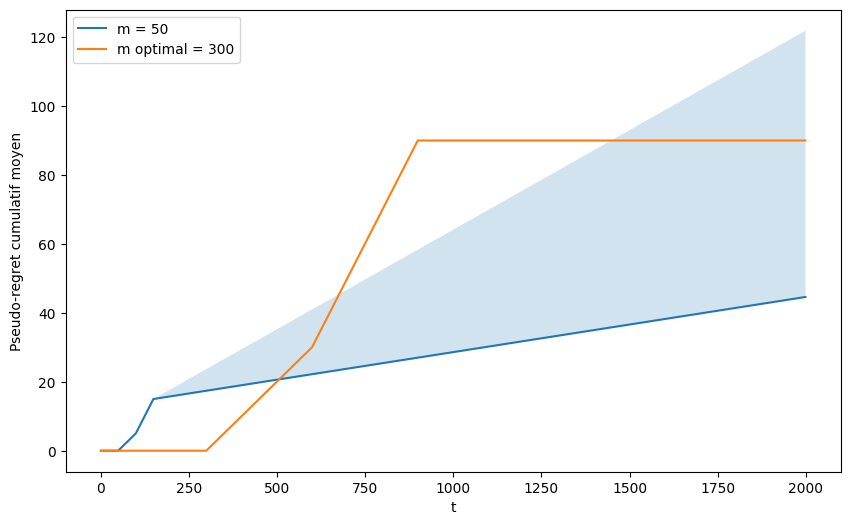

ratio_exploitation_optimale_m50 = 0.86
ratio_exploitation_optimale_m_optim = 1.0


In [9]:
# Initialisation de l'instance de la classe NormalBandit
probabilities = numpy.array([0.7, 0.6, 0.5]) # probabilités des actions
bandit = BernoulliBandit(probabilities) # initialisation du bandit selon la distribution de Bernoulli

N = 100 # nombre de réalisations
T = 2000 # horizon temporel
m = 50 # nombre de tirages exploratoires pour chaque action

# Calcul de m_optim
a_optim = numpy.argmax(probabilities) # action optimale
deltas = probabilities[a_optim] - probabilities # gaps de sous-optimalité
delta_min = probabilities[a_optim] - max(numpy.delete(probabilities, a_optim)) # gap minimal
sigma = 1/2 # car la distribution de bernoulli est sigma sous-gaussienne 1/2 ???
m_optim = numpy.ceil((4 * (sigma)**2 / delta_min**2) * numpy.log(T * delta_min**2 / (4 * (sigma)**2))) # nombre de tirages exploratoires optimal

# Pseudo-regret-cumulatif moyen pour m=50
pseudo_regrets = numpy.zeros((N, T)) # initialisation des pseudo-regrets cumulatifs de chaque réalisation
exploitation_optimale = 0 # nombre de fois où l'action optimale a été exploitée
for i in range(N):
    Na_t, Sa_t, pseudo_regret_cumulatif = etc(bandit, T, m) # réalisation i
    pseudo_regrets[i, :] = pseudo_regret_cumulatif # sauvegarde du pseudo-regret cumulatif de la réalisation i
    if numpy.argmax(Na_t) == a_optim: # si l'action optimale a été exploitée
        exploitation_optimale += 1

ratio_exploitation_optimale_m50 = exploitation_optimale / N # ratio d'exploitation optimale pour m=50
pseudo_regrets_moyens_m50 = numpy.mean(pseudo_regrets, axis=0) # pseudo-regret cumulatif moyen pour m=50
ecart_type_m50 = numpy.std(pseudo_regrets, axis=0) # écart-type du pseudo-regret cumulatif moyen pour m=50

# Pseudo-regret-cumulatif moyen pour m optimal
exploitation_optimale = 0
for i in range(N):
    Na_t, Sa_t, pseudo_regret_cumulatif = etc(bandit, T, int(m_optim)) 
    pseudo_regrets[i, :] = pseudo_regret_cumulatif
    if numpy.argmax(Na_t) == a_optim:
        exploitation_optimale += 1

ratio_exploitation_optimale_m_optim = exploitation_optimale / N # ratio d'exploitation optimale pour m optimal
pseudo_regrets_moyens_m_optim= numpy.mean(pseudo_regrets, axis=0) # pseudo-regret cumulatif moyen pour m optimal
ecart_type_m_optim = numpy.std(pseudo_regrets, axis=0) # écart-type du pseudo-regret cumulatif moyen pour m optimal

# Figure pseudo-regret cumulatif moyen
plt.figure(figsize=(10, 6))
plt.plot(pseudo_regrets_moyens_m50, label='m = 50')
plt.fill_between(numpy.arange(T), pseudo_regrets_moyens_m50, pseudo_regrets_moyens_m50 + ecart_type_m50, alpha=0.2)
plt.plot(pseudo_regrets_moyens_m_optim, label=f'm optimal = {int(m_optim)}')
plt.fill_between(numpy.arange(T), pseudo_regrets_moyens_m_optim, pseudo_regrets_moyens_m_optim + ecart_type_m_optim, alpha=0.2)
plt.xlabel('t')
plt.ylabel('Pseudo-regret cumulatif moyen')
plt.legend()
plt.show()
print(f'ratio_exploitation_optimale_m50 = {ratio_exploitation_optimale_m50}')
print(f'ratio_exploitation_optimale_m_optim = {ratio_exploitation_optimale_m_optim}')

Expliquez les régimes observés sur les courbes ainsi que les différences entre les courbes. Supportez votre discussion à l'aide des taux de convergence à l'action optimale obtenus avec chaque valeur de $m$.

La courbe en bleu (m = 50) effectue une phase d'exploration bien plus courte. Comme celle-ci commence plus vite à exploiter l'action qu'elle croit être la meilleure après seulement 150 actions, elle minimise son pseudo-regret cumulatif à court terme. Cependant, cette exploration trop brève ne lui permet pas de converger systématiquement vers l'action optimale. Cette absence de convergence est mise en évidence par la courbe de pseudo-regret cumulatif moyen, qui continue d'augmenter après la fin de la phase d'exploration.

La courbe orange (m = 300), quant à elle, effectue une exploration bien plus approfondie, mais converge toujours vers l'action optimale après 900 actions effectuées. On peut voir sa courbe de pseudo-regret cumulatif moyen cesser d'augmenter immédiatement après la phase d'exploration.

__[IFT-7201]__ Montrez comment obtenir l'équation de $m$ optimal sur un environnement à $k = 3$ actions.

### [10 points] $\varepsilon$-greedy

Complétez le code suivant pour implémenter la stratégie $\varepsilon$-greedy avec taux d'exploration $\varepsilon$ fixe. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que le taux d'exploration $\varepsilon$.

In [10]:
def egreedy(bandit, T, epsilon):
    # Initialisation
    rng = numpy.random.default_rng(0) # générateur de nombres aléatoires
    probabilities = bandit.probabilities # probabilités de succès des actions
    K = len(probabilities) # nombre d'actions
    a_optim = numpy.argmax(probabilities) # action optimale
    deltas = probabilities[a_optim] - probabilities # Gaps de sous-optimalité
    pseudo_regret_cumulatif = [] # pseudo-regret cumulatif
    Na_t = numpy.zeros(K) # nombre de fois où chaque action a été jouée
    Sa_t = numpy.zeros(K) # Somme des récompenses obtenues pour chaque action
    
    # Jouer chaque action une fois
    for action in range(K):
        Na_t[action] += 1
        reward = bandit.play(action)
        Sa_t[action] += reward
        # calcul du pseudo-regret cumulatif
        pseudo_regret_t = numpy.dot(deltas.T, Na_t) # pseudo-regret instantanné ?
        pseudo_regret_cumulatif.append(pseudo_regret_t)

    # Exploration avec probabilité epsilon et exploitation avec probabilité 1 - epsilon
    for t in range(K, T):
        exploration = rng.binomial(1, epsilon)
        if exploration:
            action = rng.integers(0, K) # exploration - choisir une action aléatoire
        else: 
            action = numpy.argmax(numpy.sum(Sa_t, axis=0) / numpy.sum(Na_t, axis=0)) # exploitation - choisir l'action avec la meilleure moyenne
        
        Na_t[action] += 1
        reward = bandit.play(action)
        Sa_t[action] += reward
        # calcul du pseudo-regret cumulatif
        pseudo_regret_t = numpy.dot(deltas.T, Na_t) # pseudo-regret instantanné ?
        pseudo_regret_cumulatif.append(pseudo_regret_t)
        
    pseudo_regret_cumulatif = numpy.array(pseudo_regret_cumulatif) # convertir la liste en array numpy pour faciliter le moyennage
    
    return Na_t, Sa_t, pseudo_regret_cumulatif

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie $\varepsilon$-greedy sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 1000$. Comparez $\varepsilon$-greedy pour $\varepsilon \in \{0, 1/8, 1/4, 1/2, 1\}$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie. Affichez le nombre de fois en moyenne (avec un écart-type) où l'action optimale est sélectionnée sur l'instance considérée avec chaque configuration de la stratégie. 

ε = 0: nombre moyen de jeux de l'action optimale = 998.00 ± 0.00
ε = 0.125: nombre moyen de jeux de l'action optimale = 915.00 ± 0.00
ε = 0.25: nombre moyen de jeux de l'action optimale = 814.00 ± 0.00
ε = 0.5: nombre moyen de jeux de l'action optimale = 639.00 ± 0.00
ε = 1: nombre moyen de jeux de l'action optimale = 325.00 ± 0.00


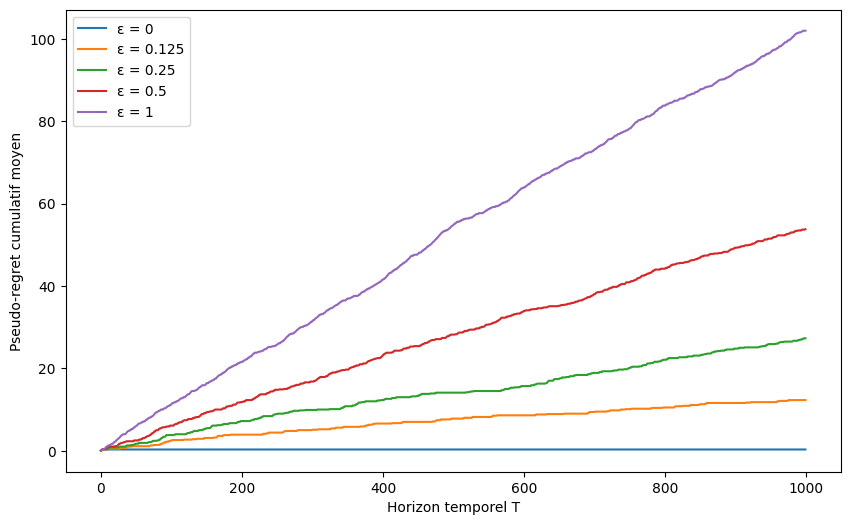

In [11]:
# Initialisation de l'instance de la classe BernoulliBandit
probabilities = numpy.array([0.7, 0.6, 0.5]) # probabilités des actions
bandit = BernoulliBandit(probabilities) # initialisation du bandit selon la distribution de Bernoulli
epsilons = [0, 1/8, 1/4, 1/2, 1] # valeurs de epsilon à tester
N = 100 # nombre de réalisations
T = 1000 # horizon temporel

N_pseudo_regrets = numpy.zeros([N, T]) # initialisation des pseudo-regrets cumulatifs de chaque réalisation
regret_moyen_epsilons = [] # pseudo-regret cumulatif moyen pour chaque valeur de epsilon
ecart_type_epsilons = []  # écart-type du pseudo-regret cumulatif moyen pour chaque valeur de epsilon
jeux_action_optimale = [] # nombre de fois où l'action optimale a été jouée en moyenne pour chaque valeur de epsilon

for epsilon in epsilons: # boucle sur les valeurs de epsilon
    nb_action_optim = [] # nombre de fois où l'action optimale a été jouée pour chaque réalisation
    for i in range(N): # boucle sur les réalisations
        Na_t, Sa_t, pseudo_regret_cumul = egreedy(bandit, T, epsilon) # réalisation i
        N_pseudo_regrets[i, :] = pseudo_regret_cumul # sauvegarde du pseudo-regret cumulatif de la réalisation i
        nb_action_optim.append(Na_t[numpy.argmax(probabilities)]) # sauvegarde du nombre de fois où l'action optimale a été jouée pour la réalisation i

    nb_action_optim_moyen = numpy.mean(nb_action_optim) # nombre moyen de fois où l'action optimale a été jouée pour epsilon
    ecart_type_action_optim = numpy.std(nb_action_optim) # écart-type du nombre de fois où l'action optimale a été jouée pour epsilon
    jeux_action_optimale.append((nb_action_optim_moyen, ecart_type_action_optim)) # sauvegarde du nombre moyen de fois où l'action optimale a été jouée pour epsilon
    
    pseudo_regret_moyen = numpy.mean(N_pseudo_regrets, axis=0) # pseudo-regret cumulatif moyen pour epsilon
    regret_moyen_epsilons.append(pseudo_regret_moyen) # sauvegarde du pseudo-regret cumulatif moyen pour epsilon
    ecart_type_epsilon = numpy.std(N_pseudo_regrets, axis=0)  # écart-type du pseudo-regret cumulatif moyen pour epsilon
    ecart_type_epsilons.append(ecart_type_epsilon) # sauvegarde de l'écart-type du pseudo-regret cumulatif moyen pour epsilon

# Figure pseudo-regret cumulatif moyen pour chaque valeur de epsilon
plt.figure(figsize=(10, 6))
for i, epsilon in enumerate(epsilons):
    plt.plot(regret_moyen_epsilons[i], label=f'ε = {epsilon}')
    plt.fill_between(numpy.arange(T), regret_moyen_epsilons[i], regret_moyen_epsilons[i] + ecart_type_epsilons[i], alpha=0.2)
    print(f'ε = {epsilon}: nombre moyen de jeux de l\'action optimale = {jeux_action_optimale[i][0]:.2f} ± {jeux_action_optimale[i][1]:.2f}')
plt.xlabel('Horizon temporel T')
plt.ylabel('Pseudo-regret cumulatif moyen')
plt.legend()
plt.show()

Expliquez les différences observées entre les courbes. Expliquez les nombres de tirages de l'action optimale en référant aux bornes inférieures sur le pseudo-regret cumulatif de la stratégie $\varepsilon$-greedy pour les configurations $\varepsilon = 0$ et $\varepsilon = 1$.

### [10 points] UCB

Complétez le code suivant pour implémenter la stratégie UCB1 (Auer et al., 2002). Votre fonction doit recevoir en entrée l'instance de bandit à aborder ainsi que la durée de l'horizon de temps $T$.

In [21]:
def ucb1(bandit, T):
    probabilities = bandit.probabilities # probabilités de succès des actions
    K = len(probabilities) # nombre d'actions
    
    a_optim = numpy.argmax(probabilities) # action optimale
    deltas = probabilities[a_optim] - probabilities # Gaps de sous-optimalité
    
    pseudo_regret_cumulatif = [] # pseudo-regret cumulatif
    Na_t = numpy.zeros(K) # nombre de fois où chaque action a été jouée
    Sa_t = numpy.zeros(K) # Somme des récompenses obtenues pour chaque action
    
    # Jouer chaque action une fois
    for t in range(T):
        if t < K:
            Na_t[t] += 1
            reward = bandit.play(t)
            Sa_t[t] += reward
            # calcul du pseudo-regret cumulatif
            pseudo_regret_t = numpy.dot(deltas.T, Na_t)
            pseudo_regret_cumulatif.append(pseudo_regret_t)
        else:
            action = numpy.argmax(Sa_t / Na_t + numpy.sqrt(numpy.log(t**4) / (2 *Na_t))) # choisir l'action avec l'indice de confiance le plus élevé
            
            # Jouer l'action choisie
            Na_t[action] += 1
            reward = bandit.play(action)
            Sa_t[action] += reward
            
            # calcul du pseudo-regret cumulatif
            pseudo_regret_t = numpy.dot(deltas.T, Na_t)
            pseudo_regret_cumulatif.append(pseudo_regret_t)
        
    pseudo_regret_cumulatif = numpy.array(pseudo_regret_cumulatif) # convertir la liste en array numpy pour faciliter le moyennage
    return Na_t, Sa_t, pseudo_regret_cumulatif
    

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie UCB1 sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 1000$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

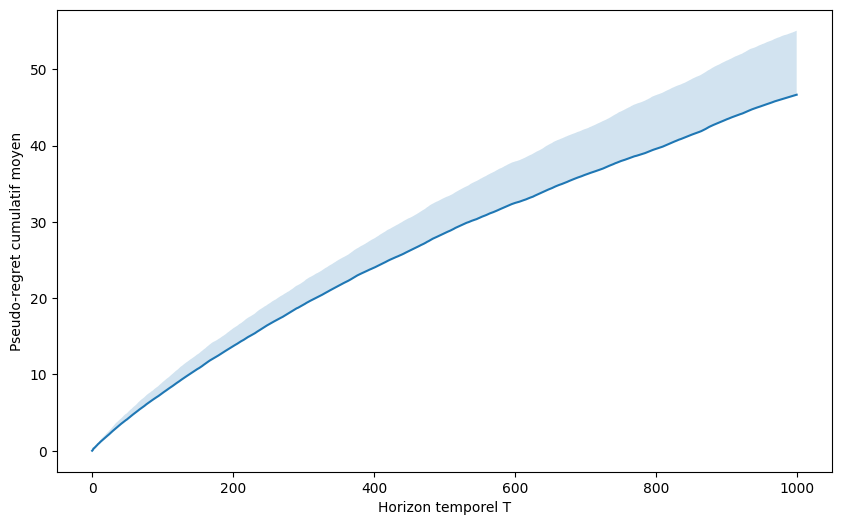

In [22]:
probabilities = numpy.array([0.7, 0.6, 0.5]) # probabilités des actions
bandit = BernoulliBandit(probabilities) # initialisation du bandit selon la distribution de Bernoulli

T = 1000 # horizon temporel
N = 100 # nombre de réalisations

pseudo_regrets = numpy.zeros([N, T]) # initialisation des pseudo-regrets cumulatifs de chaque réalisation
ecart_type_regrets = [] # écart-type du pseudo-regret cumulatif moyen

for i in range(N): # boucle sur les réalisations
    Na_t, Sa_t, pseudo_regret_cumulatif = ucb1(bandit, T) # réalisation i
    pseudo_regrets[i, :] = pseudo_regret_cumulatif # sauvegarde du pseudo-regret cumulatif de la réalisation i

pseudo_regrets_moyens = numpy.mean(pseudo_regrets, axis=0) # pseudo-regret cumulatif moyen
ecart_type_regrets = numpy.std(pseudo_regrets, axis=0) # écart-type du pseudo-regret cumulatif moyen

# Figure pseudo-regret cumulatif moyen
plt.figure(figsize=(10, 6))
plt.plot(pseudo_regrets_moyens)
plt.fill_between(numpy.arange(T), pseudo_regrets_moyens, pseudo_regrets_moyens + ecart_type_regrets, alpha=0.2)
plt.xlabel('Horizon temporel T')
plt.ylabel('Pseudo-regret cumulatif moyen')
plt.show()

Expliquez la forme de la courbe obtenue.

### [10 points] Thompson Sampling (TS)

Complétez le code suivant pour implémenter la stratégie TS destinée à des bandits stochastiques dont les récompenses suivent des distributions normales de variance connue $\sigma^2$. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, la valeur des paramètres a priori ($\mu_0$ et $\sigma_0$), ainsi que la variance des observations ($\sigma^2$).

In [13]:
def ts_normal(bandit, T, mu_0, sigma_0, sigma):
    # compléter
    pass

Considérez la classe d'environnements à 10 actions dont les récompenses suivent des distributions normales de variance $\sigma^2 = 1$ et dont les configurations sont telles que $\mu_a \sim \mathcal N(2, 1)$. Appliquez la stratégie TS à 100 instances de cette classe (une réalisation par instance) sur un horizon temporel $T = 1000$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

Justifiez le choix des paramètres a priori utilisés dans votre expérience.

### [10 points] Apprentissage par le gradient de la politique

Complétez le code suivant pour implémenter la stratégie d'apprentissage par gradient de la politique avec _baseline_ $B_t$ correspondant à la moyenne des récompenses observées jusqu'au temps $t-1$. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que le taux d'apprentissage $\alpha > 0$.

In [14]:
def policy_gradient(bandit, T, alpha):
    # compléter
    pass

Considérez la classe d'environnements à 10 actions dont les récompenses suivent des distributions normales de variance $\sigma^2 = 1$ et dont les configurations sont telles que $\mu_a \sim \mathcal N(0, 1)$. Appliquez la stratégie d'apprentissage par gradient de politique à 100 instances de cette classe (une réalisation par instance) sur un horizon temporel $T = 2000$ avec différentes valeurs de taux d'apprentissage $\alpha \in \{ 1/50, 1/10, 1/2 \}$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie.

Discutez de l'impact du taux d'apprentissage en vous appuyant sur les résultats obtenus. Expliquez notamment la forme des courbes en référant au compromis entre l'exploration et l'exploitation.

## Les bandits stochastiques contextuels

### [10 points] Les environnements de bandits stochastiques linéaires

Vous travaillez dans une entreprise comprenant différents systèmes qui mériteraient d'être optimisés. Vous aimeriez investiguer le potentiel des stratégies de bandits stochastiques linéaires pour aborder la tâche d'ajustement des paramètres d'un système de manière à maximiser sa performance.

Complétez le code suivant pour implémenter un simulateur générique permettant de réaliser des expériences sur des problèmes de bandits stochastiques linéaires adaptés à cette application. Considérez que chaque récompense $R_t$ est générée en appliquant un bruit $\eta_t \sim \mathcal N(0, \sigma^2)$ à la fonction de performance évaluée à l'action $A_t$. Votre classe doit recevoir en entrée la fonction de caractéristiques à utiliser, le paramètre $\omega_\star$ gouvernant la fonction de récompense, la variance du bruit $\sigma^2$, la liste des actions discrètres considérées ($x_1, x_2, \dots, x_k$), ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action d'indice donné.

In [15]:
class LinGaussianBandit:
    def __init__(self, phi, omega, noise_variance, action_space, seed=None):
        # compléter
        pass
    
    def play(self, action):
        # compléter
        pass

Considérez une instance spécifique de cet environnement caractérisée par une variance du bruit $\sigma^2 = 0.01$, un espace d'action $\mathcal X$ fini et discret correspondant à 100 valeurs régulièrement espacées sur l'intervalle $[0, 1]$, la fonction de caractéristique $\varphi(x) = (1, x, x^2, x^3, x^4, x^5, x^6, x^7)$, ainsi que le paramètre $\omega_\star$ suivant : 

In [16]:
omega = numpy.array([0.41218989, 0.51717332, 0.40751546, 0.03405839, -0.29501341, -0.53931605, -0.07674824, -0.10778418])

Pour montrer que votre environnement fonctionne, présentez une réalisation de cette instance pour 50 actions sélectionnées aléatoirement sur $\mathcal X$. Votre figure devrait contenir la fonction de récompense attendue en plus des récompenses échantillonnées.

À quoi pourrait correspondre le bruit dans cette application?

### [15 points] OFUL

Complétez le code suivant pour implémenter la stratégie OFUL adaptée au type d'environnement décrit précédemment. Votre fonction doit recevoir en entrée l'instance de bandits stochastiques linéaires à aborder, la durée de l'horizon de temps $T$, le paramètre de régularisation $\lambda$, la variance du bruit $\sigma^2$, ainsi que la norme $\lVert \omega_\star \rVert_2$. Considérez que la première action effectuée ($A_1$) est choisie aléatoirement uniformément sur l'espace des actions et utilisez un niveau de confiance $\delta = 1/t$.

In [17]:
def oful(bandit, T, regularization, noise_variance, norm_function):
    # compléter
    pass

Comment se traduit le niveau de confiance $\delta$ considéré sur les intervalles de confiance considérés?

Appliquez la stratégie OFUL sur $N=100$ réalisations de l'instance de bandits stochastiques linéaires décrite précédemment, sur un horizon temporel $T = 1000$ en supposant que la variance du bruit $\sigma^2$ et la norme $\lVert \omega_\star \rVert_2$ sont des informations connues. Investiguez l'impact de la régularisation en considérant $\lambda \in \{ 0.001, 0.01, 0.1, 1 \}$.

Présentez vos résultats sous la forme de figures montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

Expliquez les résultats obtenus.

__[IFT-7201]__ En pratique, il peut arriver que la variance du bruit soit inconnue, donc qu'une estimation soit utilisée. Expliquez quel sera l'impact sur l'exploration et l'exploitation si la variance du bruit est sous/sur-estimée.

### [15 points] TS pour bandits stochastiques linéaires

Complétez le code suivant pour implémenter une stratégie TS linéaire adaptée au type d'environnement décrit précédemment. Votre fonction doit recevoir en entrée l'instance de bandits stochastiques linéaires à aborder, la durée de l'horizon de temps $T$, le paramètre de régularisation $\lambda$, ainsi que la variance du bruit $\sigma^2$. Considérez que la première action effectuée ($A_1$) est choisie aléatoirement uniformément sur l'espace des actions.

In [18]:
def lints(bandit, T, regularization, noise_variance):
    # compléter
    pass

Appliquez la stratégie LinTS sur $N=100$ réalisations de l'instance de bandits décrite précédemment, sur un horizon temporel $T = 1000$ en supposant que la variance du bruit est connue. Investiguez l'impact de la régularisation en considérant $\lambda \in \{ 0.001, 0.01, 0.1, 1 \}$.

Présentez vos résultats sous la forme de figures montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

Discutez des résultats obtenus en comparaison avec les résultats obtenus en utilisant la stratégie OFUL.